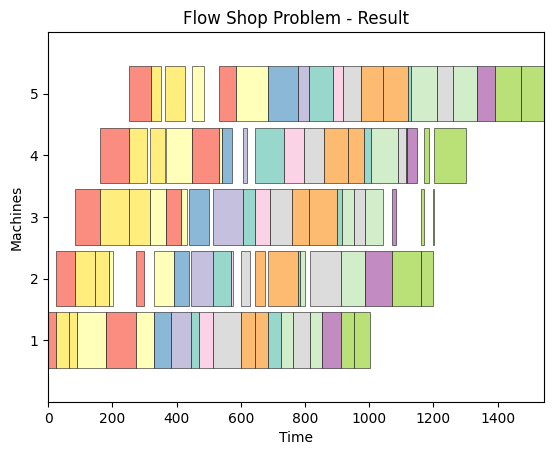

In [1]:
import flow_shop as fs

#Read and display data 
df = fs.DatasetReader('database/tai20_5.txt').read_data(1)

c_t, c_a = fs.calculate_completion_time(df, return_comp_arr=True)
fs.display_graph(df, c_t, c_a)


In [2]:
# All possible neighborhood transformation
TRANSFORMS = {
    0: fs.swap,
    1: fs.reverse_subsequence,
    2: fs.insert_before,
    3: fs.insert_after
}

TRANSFORMS_KEYS = list(TRANSFORMS.keys())

In [ ]:
# Trial implementation Tabu Search 
import random

def generate_n_different_value(n_values: int, min_value: int, max_value: int):
    if (max_value - min_value + 1) < n_values:
        raise ValueError("Incorrect range value")

    values = list()
    while len(values) < n_values:
        value = random.randint(min_value, max_value)
        if value not in values:
            values.append(value)
    
    return values


def generate_neighbor_options(n_jobs):    
    action = random.choice(TRANSFORMS_KEYS) # Roll action on set
    indexes = generate_n_different_value(2, 0, n_jobs-1) # Roll 2 indexes
    if action in [0,1]: #If action is fs.swap or fs.reverse_subsequence then sort indexes
        indexes.sort()

    return {'action': action, 'indexes': indexes}


class TabuList:
    def __init__(self, length: int) -> None:
        self.length = length
        self.tabu_list = [{'action': 0, 'indexes': [0,0]} for i in range(length)]
        self.current_index = 0 

    def __contains__(self, operation):
        return operation in self.tabu_list

    def push(self, operation: dict):
        self.tabu_list[self.current_index] = operation
        self.current_index = (self.current_index+1)%self.length

In [ ]:
x = df.processing_time.copy() #Starting solution
x_best = x.copy() # Best solution
t_best = fs.calculate_completion_time(x_best, df.n_jobs, df.m_machines) # Time of best solution

tabu_list = TabuList(8)
neighbor_size = 20 # Should be bigger than tabu list

aspiration_criterial = 10 # Better than best solution mor than aspiration_criterial

for _ in range(1000):
    #Generate neighbor solutions
    neighbor_actions = [generate_neighbor_options(df.n_jobs) for _ in range(neighbor_size)]
    neighbor_time = [1e6 for _ in range(neighbor_size)]
    for i, action in enumerate(neighbor_actions):
        xp = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
        neighbor_time[i] = fs.calculate_completion_time(xp, df.n_jobs, df.m_machines)  

    # Found best neighbor solutions
    founded_best_neighbor = False
    while len(neighbor_time) > 0 and not founded_best_neighbor:
        best_neighbor_idx = neighbor_time.index(min(neighbor_time))
        if neighbor_actions[best_neighbor_idx] in tabu_list:
            if (neighbor_time[best_neighbor_idx]+aspiration_criterial) < t_best:  
                founded_best_neighbor = True
            else:
                neighbor_time.pop(best_neighbor_idx)
        else:
            founded_best_neighbor = True
    
    if founded_best_neighbor == False:
        continue


    # If better than best solution
    action = neighbor_actions[best_neighbor_idx]
    if neighbor_time[best_neighbor_idx] < t_best:  
        t_best = neighbor_time[best_neighbor_idx]
        x_best = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
    
    x = TRANSFORMS[action['action']](x, action['indexes'][0],action['indexes'][1])
    
    tabu_list.push(action) 


In [ ]:
print("Started time: {}".format(c_t))
print("Founded solution: {}".format(t_best))
print("Low bound: {}".format(df.low_bound))

# Tabu Search
---
![Tabu Search Flow Diagram](doc/img/TabuSearch.png "Tabu Search")

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flow_shop as fs
import tabu_search as ts
import time

enum_to_str = ['SWAP', 'Reverse Subsequence', 'Insert Before', 'Insert After']
#Read and display data 
df = fs.DatasetReader('database/tai20_5.txt').read_data(1)

for m_t in ts.NeighborMoves:
    t = time.process_time() # Time measure

    data             = df.processing_time
    move_type        = m_t
    tabu_size        = 10
    aspiration_value = 20
    max_iter         = 200

    t_start = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

    t_best, x_best = ts.tabu_search(data, 
                                    move_type=move_type, 
                                    tabu_size=tabu_size, 
                                    aspiration_value=aspiration_value, 
                                    max_iter=max_iter, 
                                    return_hist=False)

    elapsed_time = time.process_time() - t # Time measure
    
    print("Tabu Search:")
    print("\t move type: {}".format(enum_to_str[move_type.value]))
    print("\t iteration: {}".format(max_iter))
    print("\t tabu list size: {}".format(tabu_size))
    print("\t aspiration criteria: {}".format(aspiration_value))
    print("\t {:.^20}".format('RESULT'))
    print("\t Starting time: {}".format(t_start))
    print("\t Best time: {}".format(t_best))


Tabu Search:
	 move type: SWAP
	 iteration: 200
	 tabu list size: 10
	 aspiration criteria: 20
	 .......RESULT.......
	 Starting time: 1545.0
	 Best time: 1365.0
Tabu Search:
	 move type: Reverse Subsequence
	 iteration: 200
	 tabu list size: 10
	 aspiration criteria: 20
	 .......RESULT.......
	 Starting time: 1545.0
	 Best time: 1366.0
Tabu Search:
	 move type: Insert Before
	 iteration: 200
	 tabu list size: 10
	 aspiration criteria: 20
	 .......RESULT.......
	 Starting time: 1545.0
	 Best time: 1365.0
Tabu Search:
	 move type: Insert After
	 iteration: 200
	 tabu list size: 10
	 aspiration criteria: 20
	 .......RESULT.......
	 Starting time: 1545.0
	 Best time: 1366.0


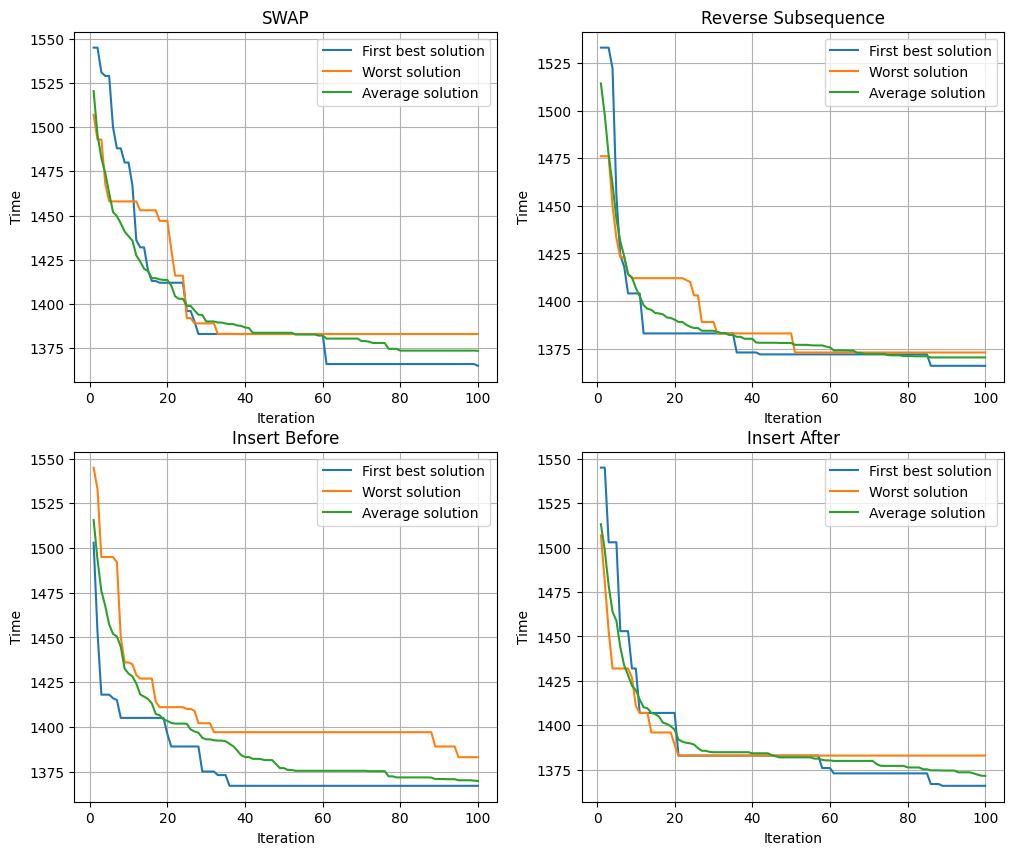

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import flow_shop as fs
import tabu_search as ts

enum_to_str = ['SWAP', 'Reverse Subsequence', 'Insert Before', 'Insert After']
#Read and display data 
df = fs.DatasetReader('database/tai20_5.txt').read_data(1)

n = 10
max_iter = 100
full_hist = np.zeros((4,n,max_iter))

for i in range(n):
    data = df.processing_time.copy()
    np.random.shuffle(data.T)

    for j, m_t in enumerate(ts.NeighborMoves):
        data             = df.processing_time
        move_type        = m_t
        tabu_size        = 10
        aspiration_value = 20
        max_iter         = max_iter

        t_start = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

        t_best, x_best, t_hist = ts.tabu_search(data, 
                                        move_type=move_type, 
                                        tabu_size=tabu_size, 
                                        aspiration_value=aspiration_value, 
                                        max_iter=max_iter, 
                                        return_hist=True)

        full_hist[j,i,:] = t_hist

fig = plt.figure()
fig.set_size_inches(12,10)
for i, m_t in enumerate(ts.NeighborMoves):
    part_hist = full_hist[m_t.value]
    min = np.argmin(part_hist[:,-1])
    max = np.argmax(part_hist[:,-1])

    plt.subplot(2,2,i+1)
    plt.plot(range(1,max_iter+1),part_hist[min,:], label="First best solution")
    plt.plot(range(1,max_iter+1),part_hist[max,:], label="Worst solution")
    plt.plot(range(1,max_iter+1),np.average(part_hist, axis=0), label="Average solution")
    plt.title(enum_to_str[i])
    plt.xlabel('Iteration')
    plt.ylabel('Time')
    plt.grid()
    plt.legend()
    
plt.show()

# Simulated Annealing
---
![Simulated Annealing Flow Diagram](doc/img/simulated_annealing.jpg "Simulated Annealing")

Simulated Annealing:
	 move type: SWAP
	 fall function: Linear
	 initial temperature: 2291.0528827669427
	 iteration: 1000
	 .......RESULT.......
	 Starting time: 1551.0
	 Best time: 1366.0


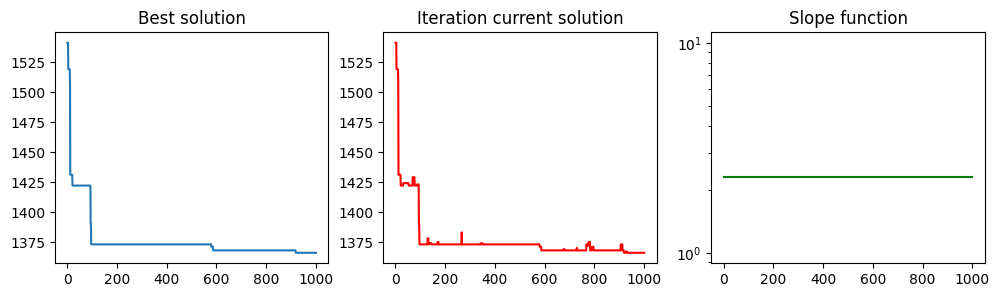

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import flow_shop as fs
import simulated_annealing as sa

import warnings
warnings.filterwarnings('ignore')


moves_to_str = ['SWAP', 'Reverse Subsequence', 'Insert Before', 'Insert After']
slope_to_str = ['Geometric', 'Logarithmic', 'Linear']
#Read and display data 
df = fs.DatasetReader('database/tai20_5.txt').read_data(1)


data = df.processing_time.copy()
np.random.shuffle(data.T)
move_type = sa.NeighborMoves.SWAP
slope_type = sa.SlopeType.LINEAR
temp_init = sa.assign_temp_init(10, 0.99)
max_iter  = int(1e3)

t_start = fs.calculate_completion_time(data, data.shape[1], data.shape[0])

t_best, x_best, hist = sa.simulated_annealing(data, 
                                            move_type=move_type, 
                                            slope_type=slope_type,
                                            temp_init=temp_init,
                                            max_iter=max_iter,
                                            return_hist=True)

print("Simulated Annealing:")
print("\t move type: {}".format(moves_to_str[move_type.value]))
print("\t fall function: {}".format(slope_to_str[slope_type.value]))
print("\t initial temperature: {}".format(temp_init))
print("\t iteration: {}".format(max_iter))
print("\t {:.^20}".format('RESULT'))
print("\t Starting time: {}".format(t_start))
print("\t Best time: {}".format(t_best))

fig = plt.figure()
fig.set_size_inches(12,3)
iter = range(1, hist.shape[0]+1)
plt.subplot(1,3,1)
plt.title("Best solution")
plt.plot(iter, hist[:,0])
plt.subplot(1,3,2)
plt.plot(iter, hist[:,1], 'r')
plt.title("Iteration current solution")
plt.subplot(1,3,3)
plt.plot(iter, hist[:,2], 'g')
plt.yscale('log')
plt.title("Slope function")
plt.show()



In [3]:
t_hist = np.zeros((10, 3))


t_hist

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])